# Tutorial
This Jupyter notebook will review how to fit a dataset with both a white noise HMM (wnHMM) and an autoregressive HMM (arHMM).

To begin, we first import some basic libraries, as well as the `OT_arHMM` package which we import as `ot` for short.

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import OT_arHMM as ot

Since the data is already saved in the Lumicks pylake format, we can load it with the `from_lk` method. We use `downsample=2` to remove effects of the antialiasing filter that has been applied to the data.

If the data is not in the pylake format, we can use the `from_data` method to load directly from the force and time data.

In [2]:
switch_file = Path("data/20220411-172711 Marker tether1-1.h5")
switch = ot.from_lk(switch_file, downsample=2)

# switch = ot.from_data(force_array, time_array, downsample=2)

We now have an object from the `Switching` class. We can print it to see all the attributes stored within the object.

In [3]:
print(switch)

Switching object for file data\20220411-172711 Marker tether1-1.h5

Raw data parameters:
	Length: 2365314 elements
	Sample rate: 78.125 kHz
	Duration: 30.28s

Downsampled data parameters:
	Downsampling factor: 2
	Length: 1182657 elements
	Sample rate: 39.062 kHz

GMM has not been fit

PSDs have not been calculated

wnHMM has not been fit

arHMM has not been fit



Before fitting the wnHMM and arHMM, we must come up with initial guesses for the various parameters to be fit. Instead of jumping straight to fitting these parameters, we have developed a method to obtain a good set of initializations by fitting the distribution of forces and the PSD.

Let's first look at the distribution of forces as a histogram.

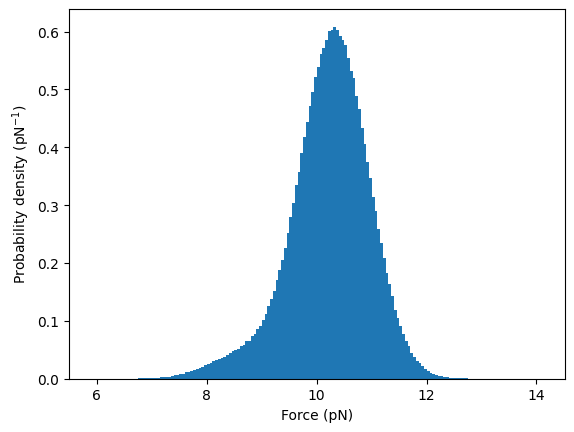

In [4]:
switch.plot_force_hist()
plt.show()

There is one dominant state at 10 pN as well as a shoulder at 8 pN which corresponds to the second state. We can fit these with a 2 state Gaussian mixture model (GMM). We must initialize the model with guesses for the weight of the two states (0.1 and 0.9), the mean force of the two states (8 and 10) and the standard deviation of each state (0.5 for both). Note that the states are by convention ordered from lowest mean force to high force throughout the entire package.

In [5]:
switch.fit_gmm([.1, .9], [8, 10], [.5, .5])

switch.plot_force_hist(color="grey")
switch.plot_gmm_pdf()
plt.show()

The GMM appears to have fit the two states well. The fit results are stored in the `Switching` object, which can be seen if we print the object again.

In [7]:
print(switch)

Switching object for file data\20220411-172711 Marker tether1-1.h5

Raw data parameters:
	Length: 2365314 elements
	Sample rate: 78.125 kHz
	Duration: 30.28s

Downsampled data parameters:
	Downsampling factor: 2
	Length: 1182657 elements
	Sample rate: 39.062 kHz

GMM has been fit with:
	Probabilities = 4.2%, 95.8%
	Means = 8.4 pN, 10.3 pN
	Std dev = 0.49 pN, 0.64 pN

PSDs have not been calculated

wnHMM has not been fit

arHMM has not been fit



Additionally, the PSD must be calculated and fit to initialize the wnHMM and arHMM. Let's calculate and plot the PSDs.

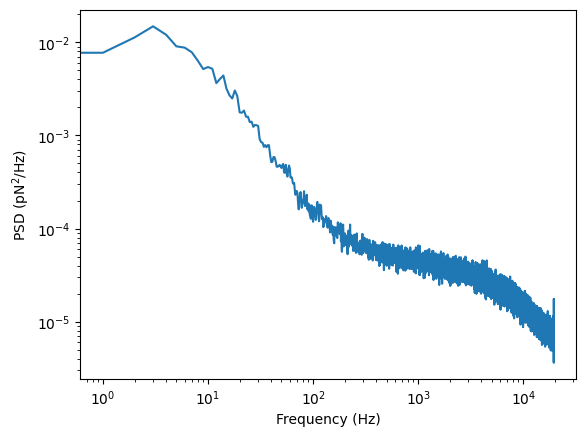

In [8]:
switch.calculate_psd()
switch.plot_psd()
plt.margins(x=0)
plt.show()

The PSD is the sum of two Lorentzians resulting from the molecular switching and the autocorrelation of the optical tweezer. We can fit this which requires initial guesses for the lower frequency Lorentzian ($A=10^{-2}$ and $f_c=10$) and the higher frequency Lorentzian ($A=3\times10^{-5}$ and $f_c=5000$).

In [9]:
switch.fit_psd(1e-2, 10, 3e-5, 5e3)

switch.plot_psd()
plt.margins(x=0)
plt.xlim(None, None)
plt.autoscale(False)
switch.plot_psd_fit()
plt.show()

The fit once again appears good and the fit results are stored inside the `Switching` object. We can now fit the wnHMM and arHMM. Note that each may take several minutes to run.

In [12]:
switch.fit_wnhmm()

In [13]:
switch.fit_arhmm()

In order to not have to rerun the full analysis, we can save the object to disk and also reload from disk with the `save` and `reload` methods.

In [20]:
#switch = switch.save("tether1-1_switching.h5")
#switch = ot.Switching.reload("tether1-1_switching.h5")

We can compare the wnHMM and the arHMM fits by examining plots of the folding survival rate.

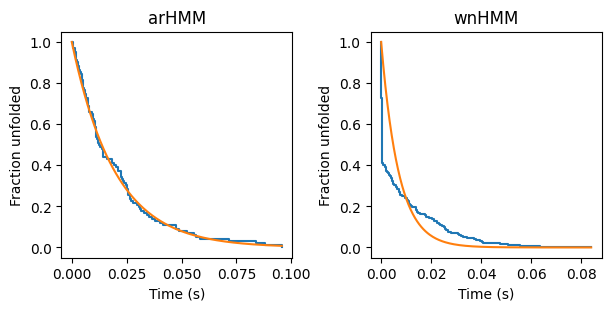

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3), layout="constrained")

switch.plot_folding_surv(ax=ax1)
switch.plot_folding_rate(ax=ax1)

switch.plot_folding_surv(wnhmm=True, ax=ax2)
switch.plot_folding_rate(wnhmm=True, ax=ax2)

ax1.set_title("arHMM")
ax2.set_title("wnHMM")
plt.show()